In [78]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .config("spark.sql.shuffle.partitions", "4") \
    .config("spark.sql.files.maxPartitionBytes", "4m") \
    .config("spark.dynamicAllocation.enabled", "false")\
    .config("spark.sql.adaptive.enabled", "false")\
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .appName("NYC Taxi ETL1") \
    .master("local[4]")\
    .getOrCreate()

In [79]:
spark

In [80]:
taxi_df =spark.read.csv(path='file:/home/jovyan/work/advanced_big_data/projects/ETL/sample.csv',
                   header=True,
                   inferSchema=True
            
)

In [81]:
taxi_df.rdd.getNumPartitions()

4

In [82]:
from pyspark.sql.functions import spark_partition_id

In [83]:
# spark.stop()

In [84]:
taxi_df.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)



In [85]:
taxi_df.createOrReplaceTempView("NYCTable")

In [86]:
taxi_df.toPandas().head(5)

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,-73.978165,40.757977,-73.989838,40.751171
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,-74.006683,40.731781,-73.994499,40.750660
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,-74.004707,40.737770,-74.009834,40.726002
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,-73.974602,40.759945,-73.984734,40.759388
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,-73.976250,40.748528,-74.002586,40.747868


In [87]:
spark.sql("SELECT COUNT(*) FROM NYCTable").show() 

+--------+
|count(1)|
+--------+
|   99999|
+--------+



In [88]:
taxi_df.columns

['medallion',
 'hack_license',
 'vendor_id',
 'rate_code',
 'store_and_fwd_flag',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'trip_time_in_secs',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude']

In [89]:
# Counting Null Values in each column
for col in taxi_df.columns:
    print(f"""{col} has {taxi_df.filter(taxi_df[col].isNull()).count()} Null Values\n
    """)

medallion has 0 Null Values

    
hack_license has 0 Null Values

    
vendor_id has 0 Null Values

    
rate_code has 0 Null Values

    
store_and_fwd_flag has 99626 Null Values

    
pickup_datetime has 0 Null Values

    
dropoff_datetime has 0 Null Values

    
passenger_count has 0 Null Values

    
trip_time_in_secs has 0 Null Values

    
trip_distance has 0 Null Values

    
pickup_longitude has 0 Null Values

    
pickup_latitude has 0 Null Values

    
dropoff_longitude has 0 Null Values

    
dropoff_latitude has 0 Null Values

    


In [90]:
# drop store_and_fwd_flag because it has 99626 null values out of 99999 records.
taxi_df=taxi_df.drop("store_and_fwd_flag")

In [91]:
taxi_df.select("medallion").distinct().count() #Number of unique taxies

6444

In [92]:
from pyspark.sql.functions import count, sum, avg, stddev_pop,max, min,asc,desc,col,unix_millis,round

In [93]:
# check if there are duplicated values based on medallion(taxi_id), pickup_datetime keys
spark.sql(""" SELECT medallion, pickup_datetime, COUNT(*) AS total_records
FROM NYCTable
GROUP BY medallion, pickup_datetime
HAVING COUNT(*) > 1
ORDER BY total_records DESC 
""").show()

+---------+---------------+-------------+
|medallion|pickup_datetime|total_records|
+---------+---------------+-------------+
+---------+---------------+-------------+



In [94]:

taxi_df.groupby("medallion", "pickup_datetime")\
.count()\
.filter(col('count') > 1).show()

+---------+---------------+-----+
|medallion|pickup_datetime|count|
+---------+---------------+-----+
+---------+---------------+-----+



# Drop trip records that has outliers.

* To execuate that task we need to compute a new column "Duration" which will be the difference between pickup time and drop off time.
  For this, we need to use unix_timestamp function to convert the date time of the respective times into milliseconds.
  We need that so we can treat the time as a numeric value and can do substraction. so that, the duration will be dropoff_ts -pickup_ts.
  after computing, we can drop records whose duration is either negative or above a given threshold, say 4 hours.  

In [95]:
taxi_df=taxi_df.withColumn("pickUp_date_MilliS",unix_millis(col("pickup_datetime")))
taxi_df=taxi_df.withColumn("dropOff_date_MilliS",unix_millis(col("dropoff_datetime")))

In [96]:
taxi_df.select(["pickup_datetime","pickUp_date_MilliS","dropoff_datetime","dropOff_date_MilliS"]).show(5)

+-------------------+------------------+-------------------+-------------------+
|    pickup_datetime|pickUp_date_MilliS|   dropoff_datetime|dropOff_date_MilliS|
+-------------------+------------------+-------------------+-------------------+
|2013-01-01 15:11:48|     1357053108000|2013-01-01 15:18:10|      1357053490000|
|2013-01-06 00:18:35|     1357431515000|2013-01-06 00:22:54|      1357431774000|
|2013-01-05 18:49:41|     1357411781000|2013-01-05 18:54:23|      1357412063000|
|2013-01-07 23:54:15|     1357602855000|2013-01-07 23:58:20|      1357603100000|
|2013-01-07 23:25:03|     1357601103000|2013-01-07 23:34:24|      1357601664000|
+-------------------+------------------+-------------------+-------------------+
only showing top 5 rows



In [97]:
taxi_df=taxi_df.withColumn("duration", (taxi_df["dropOff_date_MilliS"] - taxi_df["pickUp_date_MilliS"]))

In [98]:
taxi_df.select("duration").show(5)

+--------+
|duration|
+--------+
|  382000|
|  259000|
|  282000|
|  245000|
|  561000|
+--------+
only showing top 5 rows



In [99]:
taxi_df.filter(col("duration") < 0).count()

0

##### There is no negative value.

In [100]:
taxi_df= taxi_df.withColumn("duration_ByMin",round((taxi_df["duration"])/60000)) #convert milliseconds to minutes

In [101]:
taxi_df.select("duration_ByMin").show(5)

+--------------+
|duration_ByMin|
+--------------+
|           6.0|
|           4.0|
|           5.0|
|           4.0|
|           9.0|
+--------------+
only showing top 5 rows



In [102]:
taxi_df.filter(col("duration_ByMin") > 240.0)\
.select(["pickup_datetime","pickUp_date_MilliS","dropoff_datetime","dropOff_date_MilliS","duration","duration_ByMin"])\
.show(5)

+---------------+------------------+----------------+-------------------+--------+--------------+
|pickup_datetime|pickUp_date_MilliS|dropoff_datetime|dropOff_date_MilliS|duration|duration_ByMin|
+---------------+------------------+----------------+-------------------+--------+--------------+
+---------------+------------------+----------------+-------------------+--------+--------------+



#### There is no trip above 4 hours

### Check the percentage of ouliers in data.

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [104]:
def hist_plot(data,col_name=""):
    plt.figure(figsize=(20,8))
    sns.histplot(x=np.array(data.select(col_name).rdd.flatMap(lambda x: x).collect()),bins=30)
    plt.title("Distribution of "+re.sub("_"," ",col_name.upper()))
    plt.xticks(rotation=50);

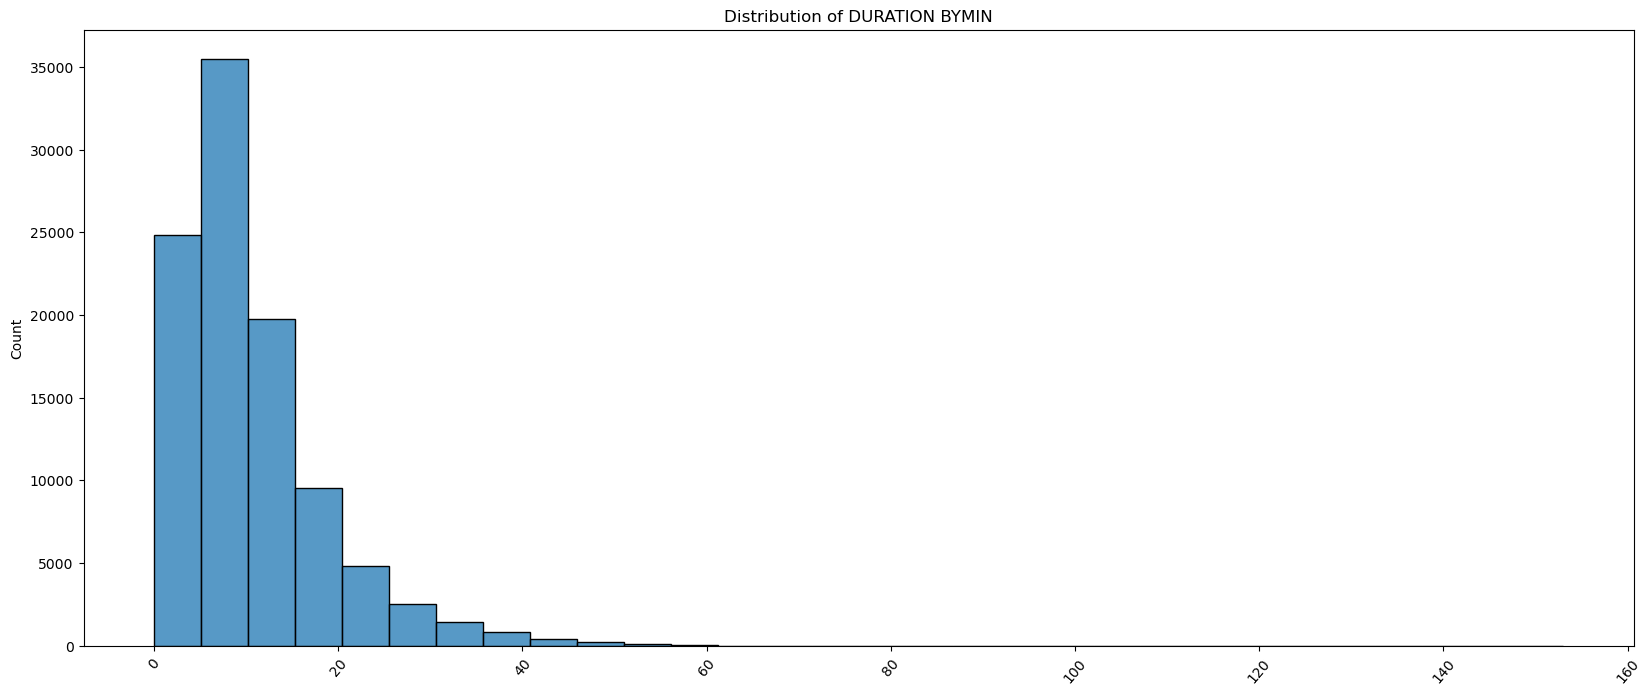

In [105]:
hist_plot(taxi_df,"duration_ByMin")

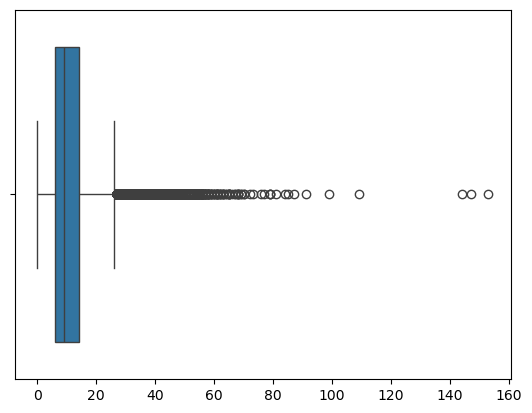

In [106]:
sns.boxplot(x=np.array(taxi_df.select("duration_ByMin").rdd.flatMap(lambda x: x).collect()));


In [107]:
# from pyspark.sql.functions import exp
def iqr_outlier_treatment(dataframe, column, factor=1.5):
    """
    Detects and treats outliers using IQR for multiple variables in a PySpark DataFrame.

    :param dataframe: The input PySpark DataFrame
    :param column: A column to apply IQR outlier treatment
    :param factor: The IQR factor to use for detecting outliers (default is 1.5)
    :return: The precentage of outliers in the data
    """

    quantiles = dataframe.approxQuantile(column, [0.25, 0.75], 0.01)
    q1, q3 = quantiles[0], quantiles[1]
    iqr = q3 - q1

    # Define the upper and lower bounds for outliers
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr

    # count outliers and return the percentage of them in data 
    percentage_of_outliers =(dataframe.count() - dataframe.filter((col(column) >= lower_bound) & (col(column) <= upper_bound)).count())\
    / dataframe.count() * 100

    return percentage_of_outliers

In [108]:
print(f"Percentage of outliers in data: {iqr_outlier_treatment(taxi_df,'duration_ByMin',factor=1.5)}")

Percentage of outliers in data: 4.290042900429005


#### Since we will need to compute the average time it takes for a taxi to find its next fare/trip per destination borough
we will not filter the outliers out.

# Create method to calculate DataFrame statistics 
Finds data for each partition
Calculate count of records, and min & max values of a column across each partition

In [109]:
from pyspark.sql.functions import spark_partition_id
def getDataFrameStats(dataFrame, columnName):

    outputDF = (
                    dataFrame

                        # Get partition number for each record
                        .withColumn("Partition Number", spark_partition_id())
        
        
                        # Group by partition, and calculate stats for a column
                        .groupBy("Partition Number")
                        .agg(
                                  count("*").alias("Record Count"),
                                  min(columnName).alias("Min Column Value"),
                                  max(columnName).alias("Max Column Value")
                            )

                        .orderBy("Partition Number")
               )

    return outputDF

In [110]:
getDataFrameStats( taxi_df, "Partition Number" ).show()

+----------------+------------+----------------+----------------+
|Partition Number|Record Count|Min Column Value|Max Column Value|
+----------------+------------+----------------+----------------+
|               0|       25286|               0|               0|
|               1|       25267|               1|               1|
|               2|       25259|               2|               2|
|               3|       24187|               3|               3|
+----------------+------------+----------------+----------------+



In [111]:
getDataFrameStats( taxi_df, "duration_ByMin" ).show()

+----------------+------------+----------------+----------------+
|Partition Number|Record Count|Min Column Value|Max Column Value|
+----------------+------------+----------------+----------------+
|               0|       25286|             0.0|            99.0|
|               1|       25267|             0.0|           153.0|
|               2|       25259|             0.0|            87.0|
|               3|       24187|             0.0|           147.0|
+----------------+------------+----------------+----------------+



# Ducomentation for shapely

In [82]:
! pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 848.5 kB/s eta 0:00:00:0100:01


In [112]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from shapely.geometry import Point

def coords_to_wkt(longitude, latitude):
    return Point(longitude, latitude).wkt

# Register the UDF in PySpark
wkt_udf = udf(coords_to_wkt, StringType())
# Add WKT point columns to the DataFrame
taxi_df = taxi_df.withColumn("pickup_point", wkt_udf("pickup_longitude", "pickup_latitude"))
taxi_df = taxi_df.withColumn("dropoff_point", wkt_udf("dropoff_longitude", "dropoff_latitude"))

In [113]:
taxi_df.select(["pickup_longitude", "pickup_latitude","pickup_point","dropoff_longitude", "dropoff_latitude","dropoff_point"])\
.toPandas().head(5)

,pickup_longitude,pickup_latitude,pickup_point,dropoff_longitude,dropoff_latitude,dropoff_point
0,-73.978165,40.757977,POINT (-73.978165 40.757977),-73.989838,40.751171,POINT (-73.989838 40.751171)
1,-74.006683,40.731781,POINT (-74.006683 40.731781),-73.994499,40.750660,POINT (-73.994499 40.75066)
2,-74.004707,40.737770,POINT (-74.004707 40.73777),-74.009834,40.726002,POINT (-74.009834 40.726002)
3,-73.974602,40.759945,POINT (-73.974602 40.759945),-73.984734,40.759388,POINT (-73.984734 40.759388)
4,-73.976250,40.748528,POINT (-73.97625 40.748528),-74.002586,40.747868,POINT (-74.002586 40.747868)


In [114]:
taxi_df.schema

StructType([StructField('medallion', StringType(), True), StructField('hack_license', StringType(), True), StructField('vendor_id', StringType(), True), StructField('rate_code', IntegerType(), True), StructField('pickup_datetime', TimestampType(), True), StructField('dropoff_datetime', TimestampType(), True), StructField('passenger_count', IntegerType(), True), StructField('trip_time_in_secs', IntegerType(), True), StructField('trip_distance', DoubleType(), True), StructField('pickup_longitude', DoubleType(), True), StructField('pickup_latitude', DoubleType(), True), StructField('dropoff_longitude', DoubleType(), True), StructField('dropoff_latitude', DoubleType(), True), StructField('pickUp_date_MilliS', LongType(), True), StructField('dropOff_date_MilliS', LongType(), True), StructField('duration', LongType(), True), StructField('duration_ByMin', DoubleType(), True), StructField('pickup_point', StringType(), True), StructField('dropoff_point', StringType(), True)])

In [115]:
taxi_df.write.option("schema",taxi_df.schema)\
.option("header",True)\
.csv("file:/home/jovyan/work/advanced_big_data/projects/ETL/taxiData2.csv/")


## Load borough_geoJson

In [116]:
#load nycgeo_boroughs.json


In [117]:
geo_Boroughs_df =spark.read.option("multiline","true") \
      .json("file:/home/jovyan/work/advanced_big_data/projects/ETL/nyc-boroughs.geojson")
geo_Boroughs_df.show()    

+--------------------+-----------------+
|            features|             type|
+--------------------+-----------------+
|[{{[[[-74.0505080...|FeatureCollection|
+--------------------+-----------------+



In [118]:
geo_Boroughs_df.printSchema()

root
 |-- features: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- geometry: struct (nullable = true)
 |    |    |    |-- coordinates: array (nullable = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |    |-- type: string (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- properties: struct (nullable = true)
 |    |    |    |-- @id: string (nullable = true)
 |    |    |    |-- borough: string (nullable = true)
 |    |    |    |-- boroughCode: long (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- type: string (nullable = true)



In [119]:
from pyspark.sql.functions import count, sum, avg, stddev_pop,max, min,asc,desc,col,unix_millis,round, explode
# Explode features to flatten the GeoJSON structure
geo_Boroughs_df = geo_Boroughs_df.select(explode("features").alias("feature"))
from pyspark.sql.functions import col
# Extract necessary fields
geo_Boroughs_df = geo_Boroughs_df.select(
    col("feature.properties.borough").alias("borough"),
    col("feature.properties.boroughCode").alias("boroughCode"),
    col("feature.geometry.coordinates").alias("coordinates")
)

geo_Boroughs_df.printSchema()

root
 |-- borough: string (nullable = true)
 |-- boroughCode: long (nullable = true)
 |-- coordinates: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: double (containsNull = true)



In [120]:
geo_Boroughs_df.show(5)

+-------------+-----------+--------------------+
|      borough|boroughCode|         coordinates|
+-------------+-----------+--------------------+
|Staten Island|          5|[[[-74.0505080640...|
|Staten Island|          5|[[[-74.0531403682...|
|Staten Island|          5|[[[-74.1594560243...|
|Staten Island|          5|[[[-74.0822127291...|
|       Queens|          4|[[[-73.8366827410...|
+-------------+-----------+--------------------+
only showing top 5 rows



In [121]:
geo_Boroughs_df.toPandas().head(5)

,borough,boroughCode,coordinates
0,Staten Island,5,"[[[-74.05050806403247, 40.566422034160816], [-..."
1,Staten Island,5,"[[[-74.05314036821109, 40.577702715545755], [-..."
2,Staten Island,5,"[[[-74.15945602438188, 40.641448333324036], [-..."
3,Staten Island,5,"[[[-74.08221272914938, 40.64828016229008], [-7..."
4,Queens,4,"[[[-73.83668274106708, 40.59494669701581], [-7..."


In [122]:
getDataFrameStats(geo_Boroughs_df,"Partition Number").show()

+----------------+------------+----------------+----------------+
|Partition Number|Record Count|Min Column Value|Max Column Value|
+----------------+------------+----------------+----------------+
|               0|         104|               0|               0|
+----------------+------------+----------------+----------------+



In [123]:
getDataFrameStats(geo_Boroughs_df,"borough").show()

+----------------+------------+----------------+----------------+
|Partition Number|Record Count|Min Column Value|Max Column Value|
+----------------+------------+----------------+----------------+
|               0|         104|           Bronx|   Staten Island|
+----------------+------------+----------------+----------------+



# Sort geo_Boroughs_df by the largest borough area.

** It is recommended to sort the GeoJson data by polygon size in a descending order to guarantee faster acess as the borough
with the largest area is expected to happen more frequently in the taxi ride dataset.

In [124]:
geo_Boroughs_df.createOrReplaceTempView("GeoBoroughsTable")

In [125]:
# assign each borough to a number, begin with the largest area, and end with the smallest one.
spark.sql("""
    SELECT * , 
    
        CASE WHEN borough = 'Queens' THEN 5
            WHEN  borough = 'Brooklyn' THEN 4
            WHEN  borough = 'Staten/ Island' THEN 3
            WHEN  borough = 'Bronx' THEN 2
            ELSE 1
        END AS borough_area_code
   
FROM
    GeoBoroughsTable
ORDER BY borough_area_code DESC   
    """
).show(5)

+-------+-----------+--------------------+-----------------+
|borough|boroughCode|         coordinates|borough_area_code|
+-------+-----------+--------------------+-----------------+
| Queens|          4|[[[-73.8271828210...|                5|
| Queens|          4|[[[-73.8049919885...|                5|
| Queens|          4|[[[-73.8260747260...|                5|
| Queens|          4|[[[-73.8324420735...|                5|
| Queens|          4|[[[-73.7942017262...|                5|
+-------+-----------+--------------------+-----------------+
only showing top 5 rows



In [126]:
geo_Boroughs_df2=spark.sql("""
    SELECT * , 
    
        CASE WHEN borough = 'Queens' THEN 5
            WHEN  borough = 'Brooklyn' THEN 4
            WHEN  borough = 'Staten Island' THEN 3
            WHEN  borough = 'Bronx' THEN 2
            ELSE 1
        END AS borough_area_code
   
FROM
    GeoBoroughsTable
ORDER BY borough_area_code DESC   
    """
)

In [127]:
geo_Boroughs_df2.show()

+-------+-----------+--------------------+-----------------+
|borough|boroughCode|         coordinates|borough_area_code|
+-------+-----------+--------------------+-----------------+
| Queens|          4|[[[-73.8597553367...|                5|
| Queens|          4|[[[-73.8366827410...|                5|
| Queens|          4|[[[-73.8133966522...|                5|
| Queens|          4|[[[-73.8271828210...|                5|
| Queens|          4|[[[-73.8260747260...|                5|
| Queens|          4|[[[-73.8324420735...|                5|
| Queens|          4|[[[-73.7942017262...|                5|
| Queens|          4|[[[-73.8050972017...|                5|
| Queens|          4|[[[-73.8049919885...|                5|
| Queens|          4|[[[-73.7395585646...|                5|
| Queens|          4|[[[-73.7394438084...|                5|
| Queens|          4|[[[-73.7905494855...|                5|
| Queens|          4|[[[-73.7667082778...|                5|
| Queens|          4|[[[

In [128]:
geo_Boroughs_df2.filter(col("borough_area_code")==1).show(2)

+---------+-----------+--------------------+-----------------+
|  borough|boroughCode|         coordinates|borough_area_code|
+---------+-----------+--------------------+-----------------+
|Manhattan|          1|[[[-74.0109284126...|                1|
|Manhattan|          1|[[[-74.0050037331...|                1|
+---------+-----------+--------------------+-----------------+
only showing top 2 rows



In [129]:
geo_Boroughs_df2.printSchema()

root
 |-- borough: string (nullable = true)
 |-- boroughCode: long (nullable = true)
 |-- coordinates: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: double (containsNull = true)
 |-- borough_area_code: integer (nullable = false)



In [130]:
from pyspark.sql.functions import udf

In [131]:
from pyspark.sql.types import StringType
from shapely.geometry import shape

# UDF to convert JSON coordinates to a Shapely polygon
def json_to_polygon(coordinates):
    try:
        geom_dict = {"type": "Polygon" if isinstance(coordinates[0][0][0], float) else "MultiPolygon", "coordinates": coordinates}
        return str(shape(geom_dict))
    except Exception as e:
        return str(e)

json_to_polygon_udf = udf(json_to_polygon, StringType())
geo_Boroughs_polygon = geo_Boroughs_df2.withColumn("polygon", json_to_polygon_udf("coordinates"))

In [132]:
geo_Boroughs_polygon.printSchema()

root
 |-- borough: string (nullable = true)
 |-- boroughCode: long (nullable = true)
 |-- coordinates: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: double (containsNull = true)
 |-- borough_area_code: integer (nullable = false)
 |-- polygon: string (nullable = true)



In [133]:
polygoncol = geo_Boroughs_polygon.select('polygon')
polygoncol.show(5)

+--------------------+
|             polygon|
+--------------------+
|POLYGON ((-73.836...|
|POLYGON ((-73.813...|
|POLYGON ((-73.827...|
|POLYGON ((-73.826...|
|POLYGON ((-73.832...|
+--------------------+
only showing top 5 rows



In [134]:
geo_Boroughs_polygon.columns

['borough', 'boroughCode', 'coordinates', 'borough_area_code', 'polygon']

In [135]:
geo_Boroughs_polygon=geo_Boroughs_polygon.select([
    'borough', 'boroughCode', 'borough_area_code', 'polygon']
)

In [136]:
geo_Boroughs_polygon.show(1)

+-------+-----------+-----------------+--------------------+
|borough|boroughCode|borough_area_code|             polygon|
+-------+-----------+-----------------+--------------------+
| Queens|          4|                5|POLYGON ((-73.836...|
+-------+-----------+-----------------+--------------------+
only showing top 1 row



In [137]:
geo_Boroughs_polygon.write.option("schema",geo_Boroughs_polygon.schema)\
.option("header",True)\
.csv("file:/home/jovyan/work/advanced_big_data/projects/ETL/geoBoroughData2.csv/")

In [138]:
spark.stop()